In [318]:
%%markdown
# Exploration

# Exploration

In [3]:
!ls -laFh /data/use-cases/service-vehicle-tracking/2018-03-trips

total 7.2M
drwxr-xr-x 4 root root  128 Mar  8 10:42 ./
drwxr-xr-x 3 root root   96 Mar  8 10:22 ../
-rw-r--r-- 1 root root 7.1M Mar  8 10:40 vehicle_trip_data.csv.bz2
-rw-r--r-- 1 root root  303 Mar  8 10:41 vehicle_trip_data_valset.csv.bz2


In [44]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

In [46]:
df_trips = pd.read_csv ('/data/use-cases/service-vehicle-tracking/2018-03-trips/vehicle_trip_data.csv.bz2')
df_cap = pd.read_csv ('/data/use-cases/service-vehicle-tracking/2018-03-trips/vehicle_trip_data_valset.csv.bz2')

In [47]:
# The epochs are counted from the 01-JAN-2000,
# whereas the standard Unix dates are counted from the 01-JAN-1970.
# There is a difference of 10,957 days
df_trips['tst_abs'] = pd.to_datetime(df_trips['tst'], unit='s') + pd.DateOffset(days = 10957)
df_trips.head()

,dev_id,tst,dst,spd,cns_tot,cns_rmg,tst_abs
0,6741,539240401,549799,0,153274.5,99,2017-02-01 05:00:01
1,6741,539243838,549799,0,153274.5,99,2017-02-01 05:57:18
2,6741,539244001,549799,0,153274.5,99,2017-02-01 06:00:01
3,6741,539247601,549799,0,153274.5,99,2017-02-01 07:00:01
4,6741,539247823,549799,0,153274.5,99,2017-02-01 07:03:43


In [48]:
df_trips.head()

,dev_id,tst,dst,spd,cns_tot,cns_rmg,tst_abs
0,6741,539240401,549799,0,153274.5,99,2017-02-01 05:00:01
1,6741,539243838,549799,0,153274.5,99,2017-02-01 05:57:18
2,6741,539244001,549799,0,153274.5,99,2017-02-01 06:00:01
3,6741,539247601,549799,0,153274.5,99,2017-02-01 07:00:01
4,6741,539247823,549799,0,153274.5,99,2017-02-01 07:03:43


In [49]:
df_trips.describe()

,dev_id,tst,dst,spd,cns_tot,cns_rmg
count,1.229017e+06,1.229017e+06,1.229017e+06,1.229017e+06,1.229017e+06,1.229017e+06
mean,4.134300e+04,5.404276e+08,3.183457e+05,2.835044e+01,6.447010e+04,6.796545e+01
std,1.981146e+04,6.987692e+05,1.335750e+05,3.739599e+01,3.703029e+04,2.102725e+01
min,6.740000e+03,5.392404e+08,6.218200e+04,0.000000e+00,5.000000e-01,0.000000e+00
25%,2.606300e+04,5.398444e+08,2.154470e+05,0.000000e+00,3.529800e+04,5.200000e+01
50%,4.749500e+04,5.404428e+08,2.959900e+05,0.000000e+00,6.174550e+04,7.100000e+01
75%,5.617000e+04,5.410318e+08,4.471890e+05,8.000000e+01,8.053600e+04,8.500000e+01
max,6.471400e+04,5.416596e+08,6.350680e+05,1.810000e+02,1.667190e+05,2.550000e+02


In [50]:
device_list = df_trips['dev_id'].unique()
len(device_list)

100

In [51]:
fuel_cap_list = df_trips['cns_rmg'].unique()
fuel_cap_list

array([ 99,  98,  97,  96,  95,  94,  93,  92,  91,  90,  89,  88,  87,
        86,  85,  83,  84,  82,  81,  80,  79,  78,  77,  76,  74,  75,
        73,  72,  71,  70,  69,  68,  67,  66,  65,  64,  63,  62,  61,
        60,  59,  58,  57,  56,  55,  54,  53,  52,  51,  50,  48,  49,
        47,  46,  45,  44,  43,  42,  41,  40,  39,  38,  37,  36,  35,
        34,  32,  33,  31,  30,  29,  28,  27,  26, 100,  25,  24,  23,
        22,  21,  20,  19,  18,  17,  16,  15,  14,  13,  12,  11,  10,
         9,   8,   7,   6,   5,   4, 255,   0,   1,   3,   2])

In [52]:
speed_list = df_trips['spd'].unique()
speed_list

array([  0,   5,  12,  29,  57,  46,  69,  16,  37,  43,  34,  28,  14,
         3,  25,  31,  15,  13,  23,   1,  17,  18,  24,  33,  32,  19,
        39,  71,  45,  58,  87,  84,  85,  76,  82,  80,  79,  70,  75,
        11,  65,  83,  81,  78,  77,  56,  59,   7,   6,   8,  41,  86,
        88,  89,  51,  90,  62,  26,  10,  67,  27,  66,  49,  35,   2,
        64,  30,  55,  22,  52,  72,  48,  61,  63,  53,   4,  50,  21,
         9,  20,  73,  68,  40,  74,  36,  54,  60,  91,  44,  38,  92,
        42,  47,  93,  95,  97,  96,  98,  99,  94, 101, 107, 100, 102,
       103, 105, 104, 111, 108, 106, 109, 158, 113, 119, 115, 180, 181])

In [53]:
df_cap.head()

,dev_id,cap
0,6740,1090
1,7733,1090
2,8789,1200
3,8793,1000
4,8794,1000


In [54]:
df_cap.describe()

,dev_id,cap
count,80.000000,80.000000
mean,40204.887500,1088.312500
std,19366.399472,268.085033
min,6740.000000,580.000000
25%,26065.250000,980.000000
50%,47451.000000,1000.000000
75%,56147.500000,1400.000000
max,62459.000000,1400.000000


In [55]:
device_cap_list = df_cap['dev_id'].unique()
len(device_cap_list)

80

In [56]:
cap_list = df_cap['cap'].unique()
cap_list

array([1090, 1200, 1000,  820,  990,  825, 1400,  980,  580,  700,  800])

In [57]:
df_full = df_trips.merge(df_cap, how='left')
df_full.head()

,dev_id,tst,dst,spd,cns_tot,cns_rmg,tst_abs,cap
0,6741,539240401,549799,0,153274.5,99,2017-02-01 05:00:01,1090.0
1,6741,539243838,549799,0,153274.5,99,2017-02-01 05:57:18,1090.0
2,6741,539244001,549799,0,153274.5,99,2017-02-01 06:00:01,1090.0
3,6741,539247601,549799,0,153274.5,99,2017-02-01 07:00:01,1090.0
4,6741,539247823,549799,0,153274.5,99,2017-02-01 07:03:43,1090.0


In [58]:
cap_full_list = df_full['cap'].unique()
cap_full_list

array([1090., 1200., 1000., 1400.,  820.,   nan,  980.,  990.,  700.,
        580.,  825.,  800.])

In [59]:
# List of vehicles for which no capacity is known
df_full[df_full['cap'].isnull()]['dev_id'].unique()

array([21951, 43371, 43373, 56167, 56175, 62461, 62463, 62981, 64711,
       43372, 43374, 43376, 50296, 56170, 62454, 64706, 64708, 64710,
       64712, 64714])

In [112]:
def plot_specific(dev_id):
    """Plot the time-series for a specific ID"""
    df_specific = df_full[df_full['dev_id'] == dev_id]
    
    plt.figure()
    fig, subaxes = plt.subplots(1, 3, figsize=(32, 10))
    df_specific.plot.scatter(x='tst', y='dst', color='Blue', label='Distance', title='Distance', ax = subaxes[0])
    df_specific.plot.scatter(x='tst', y='cns_tot', color='Green', label='Consumption', title='Consumption', ax = subaxes[1])
    df_specific.plot.scatter(x='tst', y='cns_rmg', color='Red', label='Remaining', title='Remaining', ax = subaxes[2])
    plt.show()   


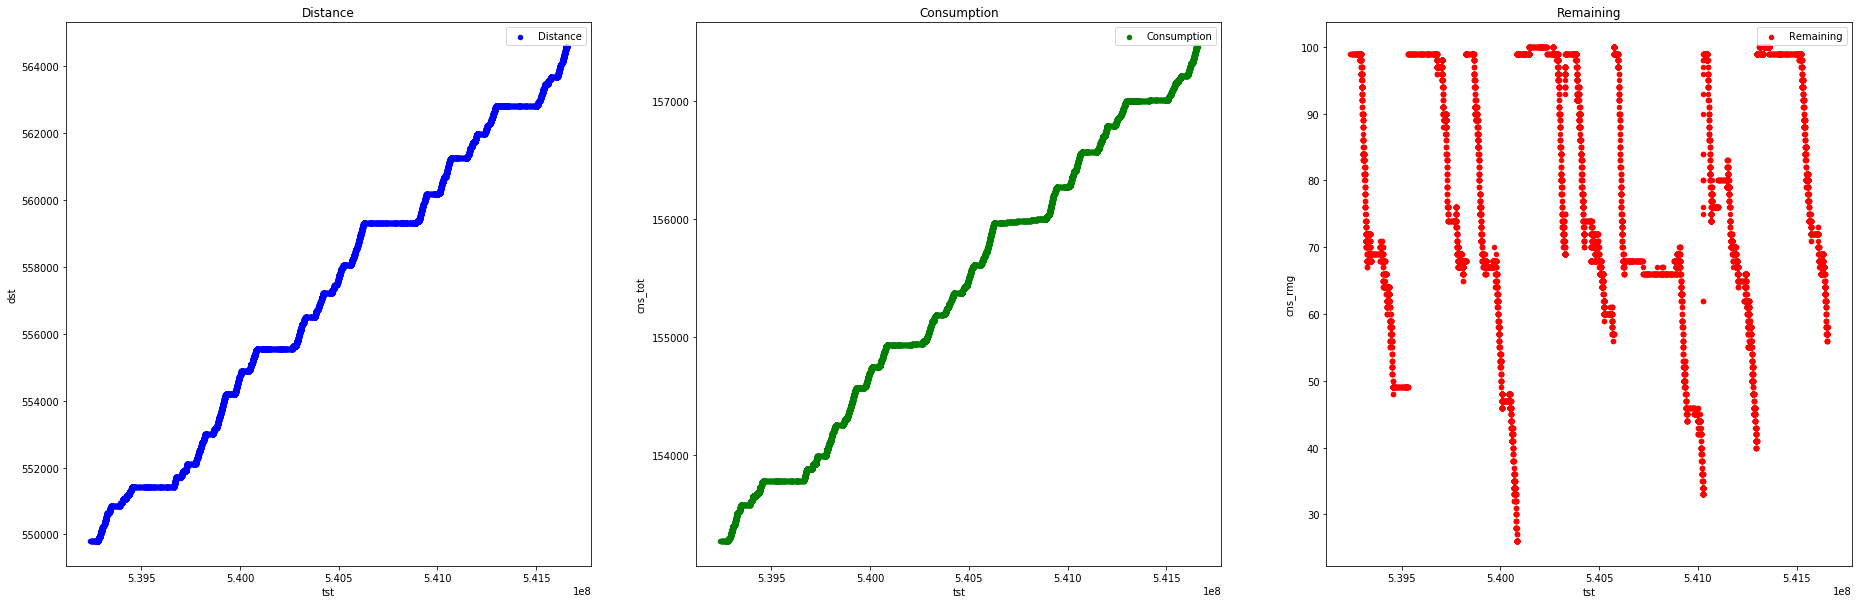

In [157]:
plot_specific(6741)

In [306]:
def get_min_max_index_lists(data):
    """Lists of indices of the minima and of the maxima.
       The values of the series always decrease, from 100 down to some minima.
       The indices are not necessarily contiguous (they correspond to
       time-stamps in seconds)"""
    last_idx = data.index[0]
    last_x = data.iloc[0]
    min_idx_list = []
    max_idx_list = [last_idx]
    first_iteration = True
    for idx, x in data.iteritems():
        if (x > 90 and x > last_x+20 and first_iteration == False):
            min_idx_list.append(last_idx)
            max_idx_list.append(idx)
        last_idx = idx
        last_x = x
        first_iteration = False
    min_idx_list.append(last_idx)
    return (min_idx_list, max_idx_list)

In [340]:
df_specific = df_full[df_full['dev_id'] == 6741]

In [341]:
df_cns = df_specific.drop_duplicates().set_index('tst')['cns_rmg']

In [342]:
df_cns.head()

tst
539240401    99
539243838    99
539244001    99
539247601    99
539247823    99
Name: cns_rmg, dtype: int64

In [343]:
(min_idx_list, max_idx_list) = get_min_max_index_lists(df_cns)

In [344]:
min_idx_list

[539531574, 539825231, 540084189, 540573560, 541297278, 541658062]

In [345]:
df_cns[min_idx_list]

tst
539531574    49
539825231    68
540084189    26
540573560    57
541297278    41
541658062    58
Name: cns_rmg, dtype: int64

In [346]:
max_idx_list

[539240401, 539532002, 539825370, 540084329, 540573708, 541297406]

In [347]:
df_cns[max_idx_list]

tst
539240401     99
539532002     99
539825370     99
540084329     99
540573708    100
541297406     99
Name: cns_rmg, dtype: int64

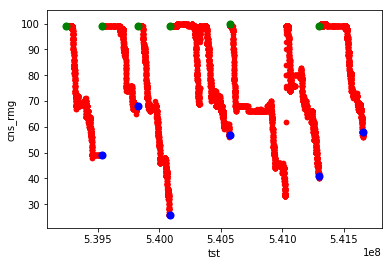

In [348]:
plt.figure()
ax = df_specific.plot.scatter(x='tst', y='cns_rmg', color='Red')
ax.scatter(x=min_idx_list, y=df_cns[min_idx_list], color='Blue', s=50)
ax.scatter(x=max_idx_list, y=df_cns[max_idx_list], color='Green', s=50)
plt.show()

In [349]:
df_all = df_specific.drop_duplicates().set_index('tst')

In [350]:
df_dst_list = df_all['dst'][min_idx_list].reset_index() - df_all['dst'][max_idx_list].reset_index()
df_dst_list

,tst,dst
0,291173,1630
1,293229,1578
2,258819,2521
3,489231,2745
4,723570,4528
5,360656,1779


In [351]:
df_cnstot_list = df_all['cns_tot'][min_idx_list].reset_index() - df_all['cns_tot'][max_idx_list].reset_index()
df_cnstot_list

,tst,cns_tot
0,291173,506.5
1,293229,475.5
2,258819,674.0
3,489231,734.5
4,723570,1327.0
5,360656,461.5


In [359]:
df_all.head()

,dev_id,dst,spd,cns_tot,cns_rmg,tst_abs,cap
tst,,,,,,,
539240401,6741,549799,0,153274.5,99,2017-02-01 05:00:01,1090.0
539243838,6741,549799,0,153274.5,99,2017-02-01 05:57:18,1090.0
539244001,6741,549799,0,153274.5,99,2017-02-01 06:00:01,1090.0
539247601,6741,549799,0,153274.5,99,2017-02-01 07:00:01,1090.0
539247823,6741,549799,0,153274.5,99,2017-02-01 07:03:43,1090.0


In [317]:
%%markdown
# Variations

# Variations

In [282]:
def get_peak_index_lists(data):
    max_peakind = signal.find_peaks_cwt(df_cns, np.arange(1, 1000))
    inv_df = 1./df_cns
    min_peakind = signal.find_peaks_cwt(inv_df, np.arange(1, 1000))
    return (min_peakind, max_peakind)

In [285]:
df_cns_rawidx = df_specific['cns_rmg']

In [286]:
(min_peakind, max_peakind) = get_peak_index_lists(df_cns_rawidx)

In [287]:
df_cns_rawidx[max_peakind]

4        99
1325     68
2492     91
3257     65
4023     71
4727     53
6081     99
7029     92
7650     71
9258     68
10667    36
Name: cns_rmg, dtype: int64

In [288]:
df_cns_rawidx[min_peakind]

4        99
1317     64
2484     90
2936     69
4015     71
4718     53
6073     99
6495     73
7638     71
9250     68
10667    36
Name: cns_rmg, dtype: int64